In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate

from ramandecompy import dataprep

In [2]:
# dataprep.new_hdf5('ML_calibration')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/water.xlsx', 'water')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx', 'hydrogen')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/Methane_Baseline_Calibration.xlsx', 'methane')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx', 'carbon monoxide')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/CO2_100wt%.csv', 'carbon dioxide')

In [3]:
dataprep.view_hdf5('ML_calibration.hdf5')

**** ML_calibration.hdf5 ****
carbon dioxide
|    Peak_01
|    Peak_02
|    counts
|    residuals
|    wavenumber
carbon monoxide
|    Peak_01
|    counts
|    residuals
|    wavenumber
hydrogen
|    Peak_01
|    Peak_02
|    Peak_03
|    Peak_04
|    counts
|    residuals
|    wavenumber
methane
|    Peak_01
|    counts
|    residuals
|    wavenumber
water
|    Peak_01
|    Peak_02
|    counts
|    residuals
|    wavenumber


### Now to write a function that will interpolate all the spectra in the hdf5_file, and sum them in a random distribution

500

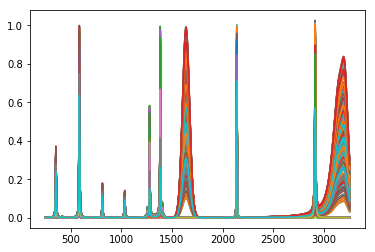

In [136]:
# first a function that will return a normalized interpolated spectra
target_compound = 'water'
# compound = 'water'
hdf5_filename = 'ML_calibration.hdf5'
spectra_count = 500

x_data, y_data, label = generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
len(x_data)

In [86]:
def generate_spectra_dataset(hdf5_filename, target_compound, spectra_count):
    """
    docstring
    """
    hdf5 = h5py.File(hdf5_filename, 'r')
    # get list of compounds from hdf5 file
    compound_list = list(hdf5.keys())
    # create list of interpolated spectra
    interp_list = []
    for compound in compound_list:
        # interpolate
        tuple_list = interp_and_norm(hdf5_filename, compound)
        interp_list.append(tuple_list)
    # identify index of target_compound
    target_index = [i for i, compound in enumerate(compound_list) if target_compound in compound][0]
    # create list of spectra
    x_data = []
    y_data = []
    label = []
    for j in range(spectra_count): 
        # apply scaling to interpolated list
        for i, tuple_list in enumerate(interp_list):
            if i == 0:
                # apply scaling
                scaled_tuple_list = apply_scaling(tuple_list, j, i, target_index)
                summed_tuples = scaled_tuple_list
            else:
                # apply scaling
                scaled_tuple_list = apply_scaling(tuple_list, j, i, target_index)    
                summed_tuples = summed_tuples + scaled_tuple_list
        # sort by wavenumber
        combined = sorted(summed_tuples)
        # add by like
        same_x = {x:0 for x, _ in combined}
        for name, num in combined:
            same_x[name] += num
        sum_combined = list(map(tuple, same_x.items()))
        # unzip
        x_combined, y_combined = zip(*sum_combined)
        # set as arrays
        x_combined = np.asarray(x_combined)
        y_combined = np.asarray(y_combined)
        # plots the spectra, will remove from final rev
        plt.plot(x_combined, y_combined)
        # export data with label (0 = no target, 1 = yes target)
        x_data.append(x_combined)
        y_data.append(y_combined)
        label.append(j % 2)
    hdf5.close()
    return x_data, y_data, label

### now a function that will generate a random number between 0 and 1 and apply that to the counts data

In [87]:
def interp_and_norm(hdf5_filename, compound):
    """
    docstring
    """
    # open hdf5_file
    hdf5 = h5py.File(hdf5_filename, 'r')
    # interpolate spectra
    x_data = np.asarray(hdf5['{}/wavenumber'.format(compound)])
    y_data = np.asarray(hdf5['{}/counts'.format(compound)])
    interp_spectra = interpolate.interp1d(x_data, y_data, kind='cubic')
    # get integer values across x_range, protecting against edge cases
    x_range = np.arange(int(min(x_data)+1), int(max(x_data)))
    y_interp = interp_spectra(x_range)
    # normalize y_interp values
    y_interp_norm = y_interp/max(y_interp)
    # zip x and y values into tuples
    tuple_list = list(zip(x_range, y_interp_norm))
    # close hdf5 file
    hdf5.close()
    return tuple_list

def apply_scaling(tuple_list, j, i ,target_index):
    """
    docstring
    """
    # unpack tuple_list
    x_data, y_data = zip(*tuple_list)
    y_data = np.asarray(y_data)
    # alternate including target_compound or not
    # if j is odd include target_compound
    if j % 2 == 1:
        if i == target_index:
            y_data_scaled = y_data*np.random.uniform(0.1, 1)
        else:
            y_data_scaled = y_data*np.random.uniform()
    # if j is even no target_compound
    elif j % 2 == 0:
        if i == target_index:
            y_data_scaled = y_data*0
        else:
            y_data_scaled = y_data*np.random.uniform() 
    else:
        pass
    # repack tuple_list
    scaled_tuple_list = list(zip(x_data, y_data_scaled))
    return scaled_tuple_list

In [88]:
HDF5_FILENAME = '../ramandecompy/tests/test_files/test_calibration.hdf5'
TARGET_COMPOUND = 'water'
HDF5 = h5py.File(HDF5_FILENAME, 'r')
X_DATA = np.asarray(HDF5['water/wavenumber'])
Y_DATA = np.asarray(HDF5['water/counts'])
TUPLE_LIST = zip(X_DATA, Y_DATA)


def test_interp_and_norm():
    """
    docstring
    """
    tuple_list = interp_and_norm(HDF5_FILENAME, TARGET_COMPOUND)
    assert isinstance(tuple_list, list), '`tuple_list is not a list'
    assert isinstance(tuple_list[0], tuple), 'first element of `tuple_list` is not a tuple'
    assert isinstance(tuple_list[0][0], np.int64), 'first element of tuple is not a np.int64'
    x_data, y_data = zip(*tuple_list)
    assert max(y_data) <= 1, 'spectra was not normalized correctly'

test_interp_and_norm()
    
def test_apply_scaling():
    """
    docstring
    """
    scaled_tuple_list = apply_scaling(TUPLE_LIST)
    assert len(scaled_tuple_list) == len(TUPLE_LIST), 'scaled data not the same size as input data'
    assert isinstance(scaled_tuple_list, list), '`scaled_tuple_list` is not a list'
    assert isinstance(scaled_tuple_list[0], tuple), 'first element of `scaled_tuple_list` is not a tuple'


### Now implement some sort of machine learning, lets start with a logistic regression

In [137]:
from sklearn.model_selection import train_test_split

# divide and extract test/train and validation data

X_train, X_test, y_train, y_test = train_test_split(y_data, label, test_size=0.2)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

400 400
100 100


In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, y_train)

# get predictions
Z = logreg.predict(X_test)

logreg.score(X_test, y_test)



1.0

In [139]:
x = x_data[0]
y = logreg.coef_.reshape(-1,1)

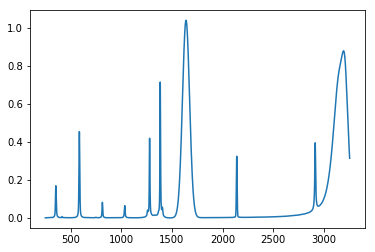

In [140]:
plt.plot(x, y)